In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
warnings.simplefilter(action='ignore')

In [25]:
FEATURES_EXCLUDED = ['']

In [81]:
data = pd.read_csv('data/clean_data_ohe.csv')
data.shape

(17831, 42)

In [83]:
target = data['bad']
data.drop(['bad', 'DaysInCollection_one'], axis=1, inplace=True)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [108]:
def cv_kfold_lgb(params, train, test, target, num_folds, metrics_f, strat=True, shfl=True, rseed=42,
                 info=False, nbr=10000, esr=200):
    print("Starting training. Train shape: {}, test shape: {}".format(train.shape, test.shape))
    
    if strat:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=shfl, random_state=rseed)
    else:
        folds = KFold(n_splits=num_folds, shuffle=shfl, random_state=rseed)

    oof_preds, sub_preds = np.zeros(train.shape[0]), np.zeros(test.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train.columns if f not in FEATURES_EXCLUDED]
    if info:
        print('Info:')
        print("Stratified: {}, Shuffle: {}, Folds:{}".format(strat, shfl, num_folds))
        print('Metrics: ', metrics_f)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats], target)):
        train_x, train_y = train[feats].iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train[feats].iloc[valid_idx], target.iloc[valid_idx]

        # set data structure
        print('Create lgbDataset!')
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)
        print('Train phase')
        reg = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            valid_names=['train', 'test'],
            num_boost_round=nbr,
            early_stopping_rounds=esr,
            verbose_eval=300,

        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test[feats], num_iteration=reg.best_iteration) / folds.n_splits

        print("CV score in {} fold: {:<8.7f}\n".format(n_fold + 1, metrics_f(valid_y, oof_preds[valid_idx])))
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = reg.feature_importance()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    return sub_preds, oof_preds, feature_importance_df

In [113]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 5,
    "num_leaves" : 31,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.8,
    "feature_fraction" : 0.8,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "seed": 42,
    "verbosity" : -1
}

In [115]:
preds, oof_preds, feat_imp = cv_kfold_lgb(lgb_params, X_train, X_test, y_train, 5, roc_auc_score, info=True)

Starting training. Train shape: (15156, 40), test shape: (2675, 40)
Info:
Stratified: True, Shuffle: True, Folds:5
Metrics:  <function roc_auc_score at 0x0000016CC28698C8>
Create lgbDataset!
Train phase
Training until validation scores don't improve for 200 rounds.
[300]	train's auc: 0.857781	test's auc: 0.81657
[600]	train's auc: 0.882605	test's auc: 0.825492
[900]	train's auc: 0.899793	test's auc: 0.828997
[1200]	train's auc: 0.914843	test's auc: 0.831937
[1500]	train's auc: 0.92646	test's auc: 0.834345
[1800]	train's auc: 0.935784	test's auc: 0.835902
[2100]	train's auc: 0.944074	test's auc: 0.837424
[2400]	train's auc: 0.950889	test's auc: 0.838658
[2700]	train's auc: 0.956643	test's auc: 0.840131
[3000]	train's auc: 0.961779	test's auc: 0.84131
[3300]	train's auc: 0.966289	test's auc: 0.843019
[3600]	train's auc: 0.970161	test's auc: 0.844208
[3900]	train's auc: 0.973258	test's auc: 0.845159
Early stopping, best iteration is:
[3830]	train's auc: 0.972509	test's auc: 0.845315
CV sc

In [116]:
roc_auc_score(y_test, preds)

0.839864689045017

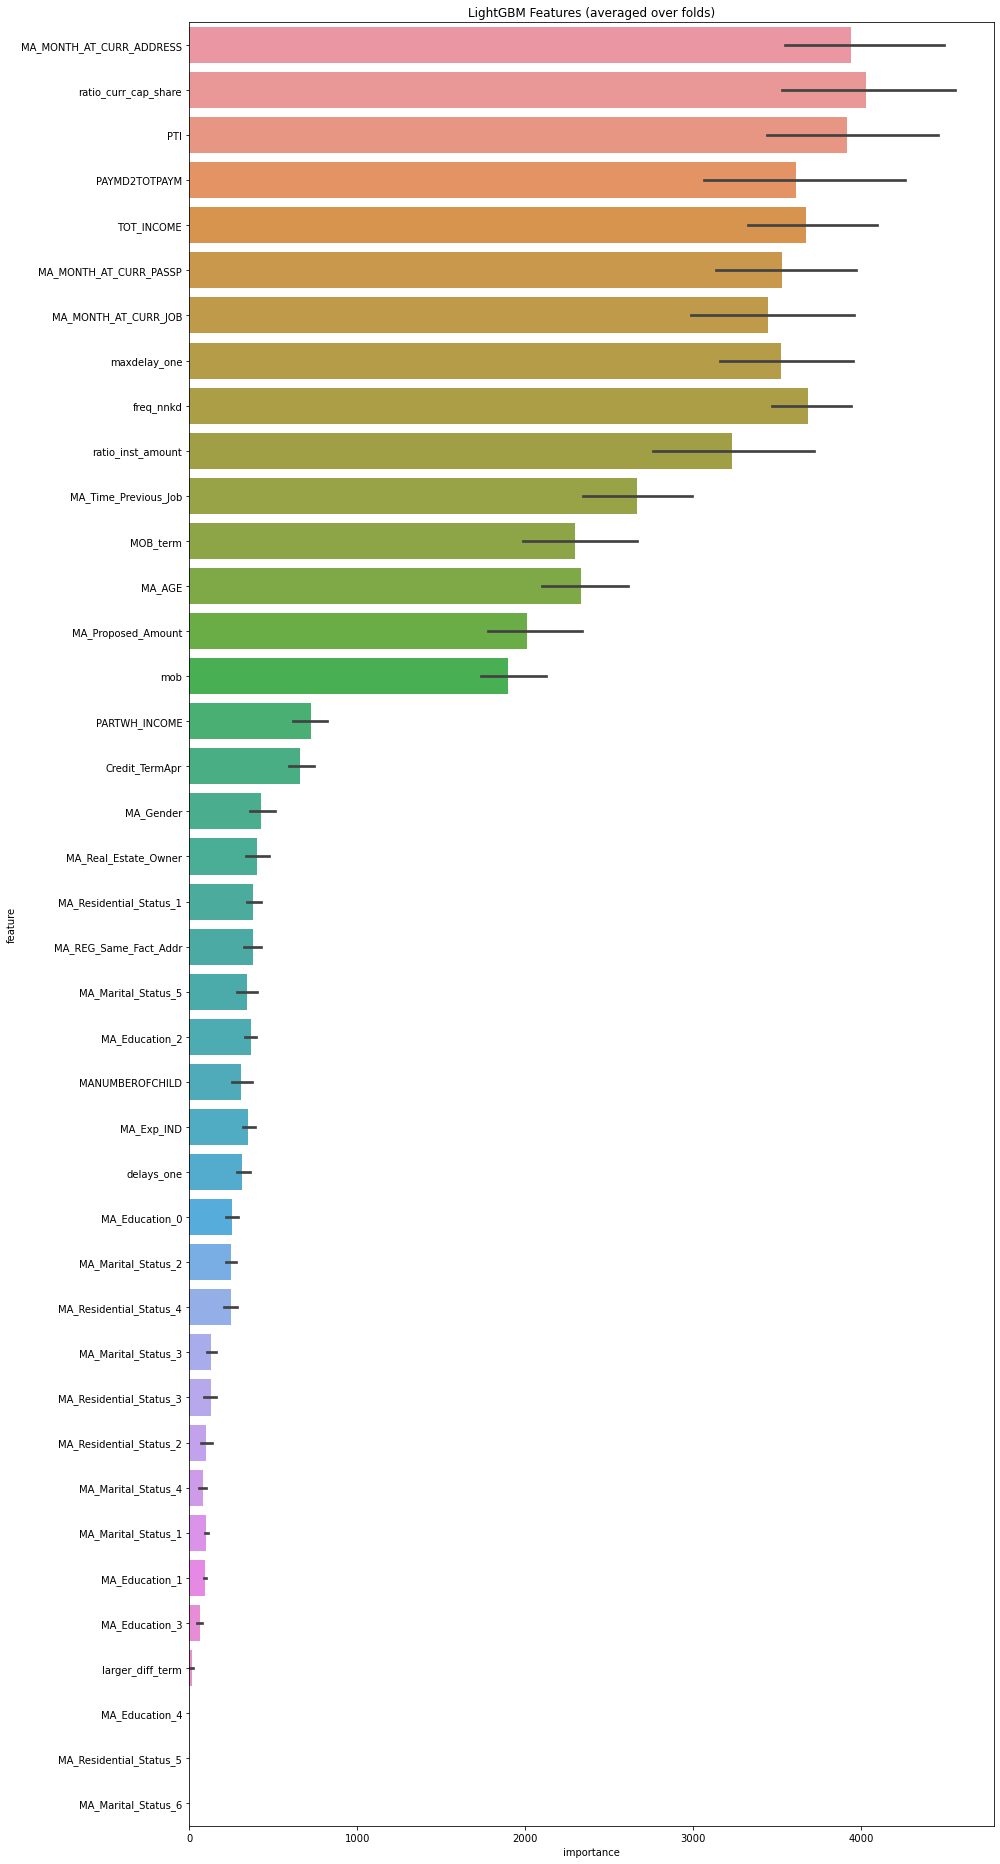

In [117]:
cols = (feat_imp[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feat_imp.loc[feat_imp.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()